<a href="https://www.kaggle.com/code/salimhammadi07/ieee-ensi-student-branch-go-data-science-gods?scriptVersionId=103760813" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Description
### Score on the Leaderboard 0.32 ( Metric is Logloss )

Potholes have become a huge problem for most drivers. With the South African government spending over R22 billion over the past 3 years on pothole repair programs and the Automobile Association(AA) acknowledging more than 5% of road deaths to unmaintained road structure (potholes).

# Imports

In [1]:
!pip install -qU fastcore fastai

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
tensorflow 2.6.2 requires numpy~=1.19.2, but you have numpy 1.20.3 which is incompatible.
tensorflow 2.6.2 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow 2.6.2 requires typing-extensions~=3.7.4, but you have typing-extensions 3.10.0.2 which is incompatible.
tensorflow 2.6.2 requires wrapt~=1.12.1, but you have wrapt 1.13.3 which is incompatible.
tensorflow-transform 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tensorflow-transform 1.5.0 requires numpy<1.20,>=1.16, but you have numpy 1.20.3 which is incompatible.
tensorflow-transform 1.5.0 requires pyarrow<6,>=1, but you have p

In [2]:
# Supress unnecessary warnings so that the presentation looks clean
import warnings
warnings.filterwarnings("ignore")

import os
from fastai.vision.all import *
import torch
import random

# Setup

Assuming provided files are present. Installing fastai (may need to restart runtime)

In [3]:
import fastai
fastai.__version__

'2.7.9'

# Load data and put in dataloaders

In [4]:
# Set the seed value all over the place to make this reproducible.
seed  = 42

def seed_value(SEED):
    random.seed(seed)
#     np.random.seed(save_model)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_value(42)

In [5]:
# Creating a new folder for saving the croped photos in it later
!mkdir data_crop

In [6]:
# crop the images and save in data_crop folder
# get all the filenames
all_files = []
data = '../input/miia-pothole-image-classification-challenge/all_data/all_data'
for path, subdirs, files in os.walk(data):
    for name in files:
        all_files.append(os.path.join(path, name))
        
for f in all_files:
    temp_img = Image.open(f)
    
    # Croped 190 pixcel from top /230 pixcel from bottom
    
    temp_img = temp_img.crop((0, 190, 800, 600-230))
    temp_img.save('./data_crop' + f.split(data)[1])

In [7]:
train = pd.read_csv('../input/miia-pothole-image-classification-challenge/train_ids_labels.csv')
print(train.shape)
train.head(2)

(4026, 2)


,Image_ID,Label
0,cVOfkSdqnWXUerr,0
1,EhnvIDPXFFjUhkR,0


In [8]:
test = pd.read_csv('../input/miia-pothole-image-classification-challenge/test_ids_only.csv')
print(test.shape)
test.head(2)

(1650, 1)


,Image_ID
0,nRhHxqLhDlJsiXc
1,gbSntVovxgHQrmO


In [9]:
# Add the image filenames (will be useful)
train['fn'] = train['Image_ID'].map(lambda s: './data_crop/'+'_'.join(s.split('_')[:2]))
test['fn'] = test['Image_ID'].map(lambda s: './data_crop/'+'_'.join(s.split('_')[:2]))

# class distribution

<AxesSubplot:>

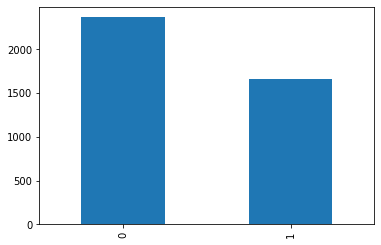

In [10]:
train['Label'].value_counts().plot.bar()

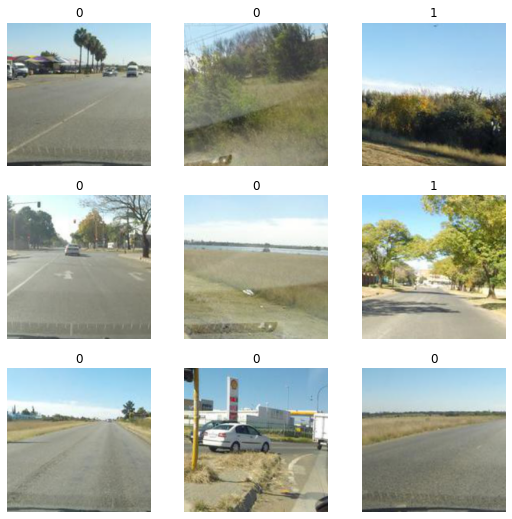

In [11]:
# Data augmentation
augmentations = [
    Rotate(p=0.5,draw=90), Rotate(p=0.5,draw=-90), Rotate(p=0.5,draw=-30), Rotate(p=0.5,draw=30), Rotate(p=0.5,draw=-15), Rotate(p=0.5,draw=15), Rotate(p=0.5,draw=-10),
    Rotate(p=0.5,draw=10), Flip(p=1),
    ]
dls = ImageDataLoaders.from_df(train, batch_tfms=augmentations, num_workers=0, bs=64, valid_pct=0.2, fn_col='fn'
                               , label_col='Label', suff='.JPG', item_tfms=Resize(224))
dls.show_batch()

# Quick Model



In [12]:
learn = cnn_learner(dls, models.alexnet, metrics=[error_rate,accuracy,], pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

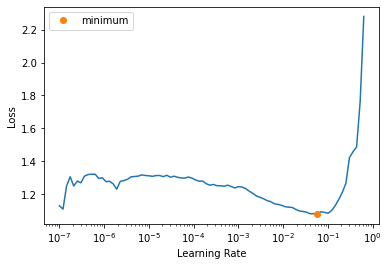

In [13]:
m = learn.lr_find(suggest_funcs=(minimum))
epochs = 10
m = m.minimum

In [14]:
learn.fit_one_cycle(epochs, slice(m/10, m))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.892661,0.350489,0.145342,0.854658,00:22
1,0.715824,0.336163,0.149068,0.850932,00:22
2,0.624157,0.329055,0.139130,0.860870,00:22
3,0.551193,0.287056,0.124224,0.875776,00:22
4,0.521355,0.303027,0.118012,0.881988,00:22
5,0.486429,0.297671,0.119255,0.880745,00:23
6,0.466100,0.278823,0.098137,0.901863,00:22
7,0.436861,0.269197,0.108075,0.891925,00:22
8,0.415932,0.272087,0.110559,0.889441,00:22
9,0.408621,0.268159,0.108075,0.891925,00:22


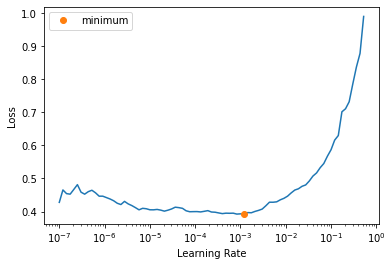

In [15]:
learn.unfreeze()
m = learn.lr_find(suggest_funcs=(minimum))
m = m.minimum

In [16]:
learn.fit_one_cycle(epochs, slice(m/10, m))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.389346,0.258879,0.103106,0.896894,00:24
1,0.377449,0.243695,0.096894,0.903106,00:24
2,0.347303,0.237826,0.093168,0.906832,00:24
3,0.339092,0.239382,0.088199,0.911801,00:23
4,0.316814,0.225282,0.091925,0.908075,00:24
5,0.312460,0.214192,0.074534,0.925466,00:24
6,0.290432,0.211633,0.078261,0.921739,00:24
7,0.278302,0.206733,0.077019,0.922981,00:23
8,0.268552,0.206153,0.077019,0.922981,00:24
9,0.273899,0.205494,0.078261,0.921739,00:24


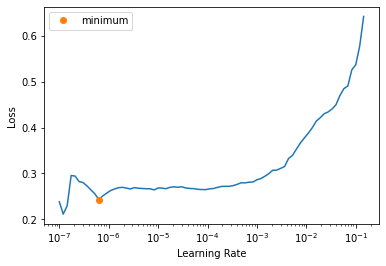

In [17]:
learn.unfreeze()
m = learn.lr_find(suggest_funcs=(minimum))
m = m.minimum

In [18]:
learn.fit_one_cycle(5, slice(m/10, m))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.258111,0.205567,0.077019,0.922981,00:24
1,0.270473,0.204941,0.077019,0.922981,00:24
2,0.264945,0.204787,0.077019,0.922981,00:24
3,0.269702,0.205582,0.078261,0.921739,00:24
4,0.274103,0.206218,0.077019,0.922981,00:24


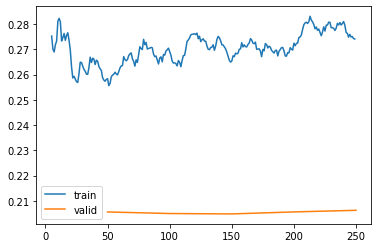

In [19]:
learn.recorder.plot_loss()

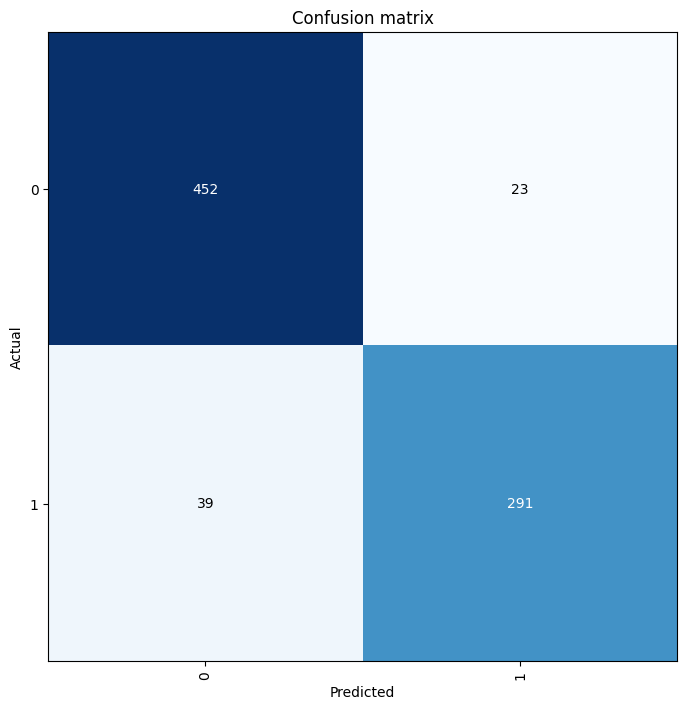

In [20]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7, 7), dpi=100)

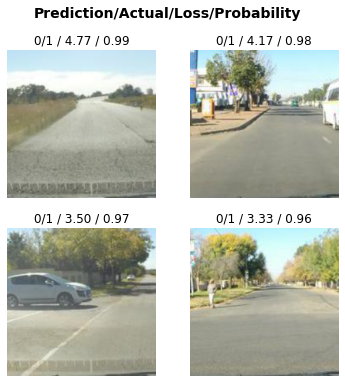

In [21]:
interp.plot_top_losses(4)

# Submission

In [22]:
preds = learn.get_preds(dl=dls.test_dl(test)) # Getting the predicted probabilities

In [23]:
sub=pd.read_csv('../input/miia-pothole-image-classification-challenge/sample_submission.csv')

In [24]:
submission = pd.DataFrame()
submission["Image_ID"] = test["Image_ID"]
submission[["test","Label"]]= np.array(preds[0])
submission = submission.drop(columns ="test")
submission.head(15)

,Image_ID,Label
0,nRhHxqLhDlJsiXc,0.084999
1,gbSntVovxgHQrmO,0.506732
2,nqOobGmvgEOiPms,0.040445
3,oIkPTooLcIbZKlF,0.862870
4,eSKxsTTJDQzkjgD,0.243815
5,fGOKonqqErFfiuK,0.998959
6,UZPfNzWrCgFaaNz,0.170083
7,kvesbcrtTOohiLT,0.075252
8,cdEZEDZaveknkKa,0.057627
9,GaSSOeqyIktsAmW,0.121571


In [25]:
submission.to_csv('sub.csv', index=False)